## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://dl.dropboxusercontent.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2025-01-21 17:11:28--  https://dl.dropboxusercontent.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.69.15
Connessione a dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.69.15|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 33179236 (32M) [text/plain]
Salvataggio in: «/Users/gabrielepoccianti/data/data_000637.txt.11»

data_000637.txt.11  100%[===================>]  31,64M  24,2MB/s    in 1,3s    

2025-01-21 17:11:30 (24,2 MB/s) - «/Users/gabrielepoccianti/data/data_000637.txt.11» salvato [33179236/33179236]



1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [4]:
import pandas as pd

N=int(2*1e5)
df=pd.read_csv("data_000637.txt",nrows=N)

df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


2\. Find out the number of BX in a ORBIT (the value 'x').

In [5]:
print("There are", df['BX_COUNTER'].max(), "BX in an orbit")
x=df['BX_COUNTER'].max()

There are 3563 BX in an orbit


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [6]:
#We read the whole dataset
df=pd.read_csv("data_000637.txt")
df["time_ns"]=df["ORBIT_CNT"]*x*25+df["BX_COUNTER"]*25+df["TDC_MEAS"]*25/30
time_last=df["time_ns"].max()-df["time_ns"].min()
print("Time last: ",time_last,"ns")

Time last:  980141153.3125 ns


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [7]:
print(df["time_ns"])

0          3.446490e+14
1          3.446490e+14
2          3.446490e+14
3          3.446490e+14
4          3.446490e+14
               ...     
1310715    3.446500e+14
1310716    3.446500e+14
1310717    3.446500e+14
1310718    3.446500e+14
1310719    3.446500e+14
Name: time_ns, Length: 1310720, dtype: float64


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
head_new=np.random.choice([0,1],len(df))
df1=df.copy() #new dataset
df["HEAD"]=head_new

6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [9]:
head_new=np.ones(len(df))
df2=df.copy()
df2["HEAD"]=head_new
df2.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
0,1.0,0,123,3869200167,2374,26,3.446490e+14
1,1.0,0,124,3869200167,2374,27,3.446490e+14
2,1.0,0,63,3869200167,2553,28,3.446490e+14
3,1.0,0,64,3869200167,2558,19,3.446490e+14
4,1.0,0,64,3869200167,2760,25,3.446490e+14


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

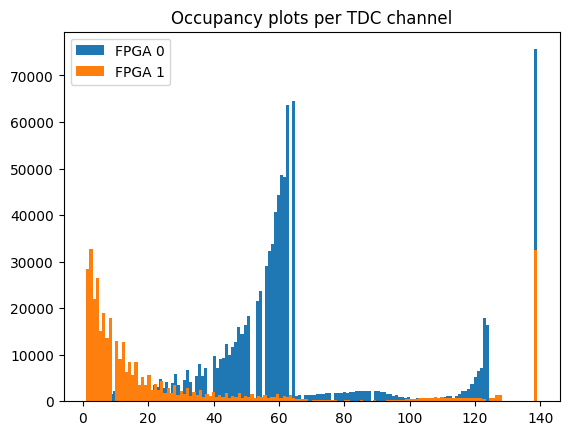

In [64]:
df.head()

dg0=df[df["FPGA"]==0]["TDC_CHANNEL"]
dg1=df[df["FPGA"]==1]["TDC_CHANNEL"]

plt.hist(dg0,bins=149,label="FPGA 0");
plt.hist(dg1,bins=140, label="FPGA 1");
plt.legend()
plt.title("Occupancy plots per TDC channel")
plt.show()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [96]:
dg=df.groupby("TDC_CHANNEL").count()
noisy_ch=np.sort(dg["HEAD"])[-3:] #We choose a random channel (they all have the same number of counts), then we revert and consider the first three
print("The most three noisy channels are: \n", noisy_ch)

The most three noisy channels are: 
 [ 64642  66020 108059]


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [90]:
masked_df=df[df["TDC_CHANNEL"]==139]

grouped_masked_df= masked_df.groupby('ORBIT_CNT').size()

print("the number of unique orbits with at least one measurement from TDC_CHANNEL=139 are ", len(grouped_masked_df))

the number of unique orbits with at least one measurement from TDC_CHANNEL=139 are  10976
